# Estatística Básica

In [1]:
!pip install factor_analyzer
!pip install plotly --upgrade

     |████████████████████████████████| 40kB 3.4MB/s 
  Created wheel for factor-analyzer: filename=factor_analyzer-0.3.2-cp37-none-any.whl size=40383 sha256=13e5d0e3a464431cd9cbae5123ce21366ee0ef8256f2856869d1afc0d74cbb4b
  Stored in directory: /root/.cache/pip/wheels/4a/d0/57/f1330cb9c80e82d8d05391c74c94ed61ce3f03bf6157f3d6db
Successfully built factor-analyzer
     |████████████████████████████████| 13.2MB 278kB/s 
  Found existing installation: plotly 4.4.1
    Uninstalling plotly-4.4.1:
      Successfully uninstalled plotly-4.4.1


In [83]:
import numpy as np
import pandas as pd
from copy import copy
from scipy import stats
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_kmo
import matplotlib.pyplot as plt
import seaborn as sn
import plotly.graph_objects as go

# Código para melhorar a visualização da tabela
pd.options.display.max_columns = None
pd.options.display.max_rows = 20
pd.options.display.float_format = "{:,.2f}".format

# Código para melhorar prints com numpy
np.set_printoptions(precision = 3)
np.set_printoptions(suppress=True)

# Banco de Dados

Nós vamos utilizar um banco de dados sobre os jogos da Copa do Mundo da FIFA de 2018.

Para entendermos melhor, abaixo está uma descrição de cada variável do dataset:

* data: Data da partida
* time: Time que está sendo analisado na partida
* oponente: Time oponente
* gols: Número de gols marcados pelo time
* dominio: Porcentagem do tempo em que a bola ficou no domínio do time
* tentativas: Número de tentativas de fazer um gol
* no_alvo: Número de chutes pro gol que acertaram a área do gol
* fora_alvo: Número de chutes pro gol que não acertaram a área do gol
* bloqueios: Número de tentativas do time oponente de fazer gol que foram bloqueadas pelo time
* escanteios: Número de escanteios utilizados pelo time
* impedimento: Número de impedimentos no futebol
* jogadas_livres: Número de faltas cometidas
* defesas: Número de defesas realizadas pelo goleiro do time
* acuracia_passes: Porcentagem de passes realizados com sucesso para outro jogador do time
* passes: Número total de passes realizados pelo time
* distancia: Distância em quilômetros percorrida no total pelos jogadores do time
* faltas: Número de faltas cometidas pelos jogadores do time
* amarelos: Número de avisos amarelos recebidos pelo time
* amarelos_vermelhos: Número de avisos amarelos e vermelhos recebidos
* vermelhos: Número de cartões vermelhos recebidos pelo time
* homem_do_jogo: Se o homem do jogo foi um jogador do time (1) ou do time oponente (0)
* primeiro_gol: Tempo em que o primeiro gol do time foi marcado
* rodada: Fase da partida
* penalti: Esse jogo teve penalti? Sim (1) / Não (0)
* gols_penalti: Número de gols marcados em penaltis
* gol_contra: Número de gols contra
* tempo_gol_contra: Tempo em que o gol contra ocorreu



In [3]:
# Caminho para importação dos dados
filepath = 'FIFA 2018 Statistics.csv'

colunas = ['data','time','oponente','gols','dominio','tentativas','no_alvo','fora_alvo','bloqueios','escanteios','impedimento','jogadas_livres','defesas',
           'acuracia_passes','passes','distancia','faltas','amarelos','amarelos_vermelhos','vermelhos','homem_do_jogo',
           'primeiro_gol','rodada','penalti','gols_penalti','gols_contra','tempo_gol_contra']

# Leitura dos dados
data = pd.read_csv(filepath, names = colunas, header=0)
data.head()

,data,time,oponente,gols,dominio,tentativas,no_alvo,fora_alvo,bloqueios,escanteios,impedimento,jogadas_livres,defesas,acuracia_passes,passes,distancia,faltas,amarelos,amarelos_vermelhos,vermelhos,homem_do_jogo,primeiro_gol,rodada,penalti,gols_penalti,gols_contra,tempo_gol_contra
0,14-06-2018,Russia,Saudi Arabia,5,40,13,7,3,3,6,3,11,0,78,306,118,22,0,0,0,Yes,12.00,Group Stage,No,0,nan,nan
1,14-06-2018,Saudi Arabia,Russia,0,60,6,0,3,3,2,1,25,2,86,511,105,10,0,0,0,No,nan,Group Stage,No,0,nan,nan
2,15-06-2018,Egypt,Uruguay,0,43,8,3,3,2,0,1,7,3,78,395,112,12,2,0,0,No,nan,Group Stage,No,0,nan,nan
3,15-06-2018,Uruguay,Egypt,1,57,14,4,6,4,5,1,13,3,86,589,111,6,0,0,0,Yes,89.00,Group Stage,No,0,nan,nan
4,15-06-2018,Morocco,Iran,0,64,13,3,6,4,5,0,14,2,86,433,101,22,1,0,0,No,nan,Group Stage,No,0,1.00,90.00


In [4]:
# Substituição de NaN por zeros e de texto em valores numéricos
data.loc[pd.isnull(data['gols_contra']),'gols_contra'] = 0 # Colunas que possuíam NaN
data.loc[pd.isnull(data['tempo_gol_contra']),'tempo_gol_contra'] = 0 # Colunas que possuíam NaN
data.loc[pd.isnull(data['primeiro_gol']),'primeiro_gol'] = 0 # Colunas que possuíam NaN
data.loc[data['homem_do_jogo']=='Yes','homem_do_jogo'] = 1 # Transformando de texto em  numéricos
data.loc[data['homem_do_jogo']=='No','homem_do_jogo'] = 0 # Transformando de texto em  numéricos
data.loc[data['penalti']=='Yes','penalti'] = 1 # Transformando de texto em  numéricos
data.loc[data['penalti']=='No','penalti'] = 0 # Transformando de texto em  numéricos

# Deletar colunas que não queremos utilizar
data = data.drop(columns=['data', 'time', 'oponente', 'rodada'])
display(data)

,gols,dominio,tentativas,no_alvo,fora_alvo,bloqueios,escanteios,impedimento,jogadas_livres,defesas,acuracia_passes,passes,distancia,faltas,amarelos,amarelos_vermelhos,vermelhos,homem_do_jogo,primeiro_gol,penalti,gols_penalti,gols_contra,tempo_gol_contra
0,5,40,13,7,3,3,6,3,11,0,78,306,118,22,0,0,0,1,12.00,0,0,0.00,0.00
1,0,60,6,0,3,3,2,1,25,2,86,511,105,10,0,0,0,0,0.00,0,0,0.00,0.00
2,0,43,8,3,3,2,0,1,7,3,78,395,112,12,2,0,0,0,0.00,0,0,0.00,0.00
3,1,57,14,4,6,4,5,1,13,3,86,589,111,6,0,0,0,1,89.00,0,0,0.00,0.00
4,0,64,13,3,6,4,5,0,14,2,86,433,101,22,1,0,0,0,0.00,0,0,1.00,90.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,1,46,11,1,6,4,4,3,24,5,79,479,148,14,1,0,0,0,5.00,0,0,0.00,0.00
124,2,43,12,4,3,5,4,1,5,5,88,510,108,11,1,0,0,1,4.00,0,0,0.00,0.00
125,0,57,15,5,7,3,5,0,12,2,92,698,110,5,2,0,0,0,0.00,0,0,0.00,0.00
126,4,39,8,6,1,1,2,1,14,1,75,271,99,14,2,0,0,1,18.00,0,0,1.00,18.00


In [5]:
# Número de linhas (amostras) e colunas (variáveis) na base de dados 

[n_linhas, n_columns] = data.shape
print('Número de variáveis = ', n_columns)
print('Número de jogos no dataset = ', n_linhas)

Número de variáveis =  23
Número de jogos no dataset =  128


# Exercício 1
## Média, Quantis e Desvio-Padrão

Vamos calcular alguns valores de média, mediana variância, desvio-padrão e alguns quantis para começarmos a nos famialiarizar com funções e bibliotecas utilizadas em ciência de dados.

Se 'data' é a sua tabela e 'coluna' o nome da coluna que você deseja analisar, esses comando da biblioteca pandas podem ser úteis:

* data['coluna'].mean() para encontrar a média da variável
* data['coluna'].median() para encontrar a mediana da variável
* data['coluna'].quantile(x) para encontrar o quantil x da variável (utilize um número decimal entre 0 e 1)
* data['coluna'].std( ) para encontrar o desvio-padrão

Utilizando a biblioteca scipy é possível realizar o contrário e descobrir qual o quantil de um determinado valor X. 
* stats.percentileofscore(data['coluna'],x)

Utilize a célula abaixo para calcular:

a) A distância média em quilômetros percorrida pelos times ao londo do jogo;

b) A mediana da distância percorrida pelos times ao londo do jogo;

c) Entre quais percentis está a distância de 115 Km

In [84]:
# a
print("A distância média em km percorrida pelos times:{} \n".format(data['distancia'].mean()))

# b
print("A mediana da distância percorrida pelos times: {} \n".format(data['distancia'].median()))

#c
print("Entre quais percentis está a distância de 115 Km: Abaixo de {} \n".format(stats.percentileofscore(data['distancia'], 115)))


A distância média em km percorrida pelos times:106.6640625 

A mediana da distância percorrida pelos times: 104.5 

Entre quais percentis está a distância de 115 Km: Abaixo de 89.453125 



# Exercício 2

## Histograma e Boxplot

Agora, vamos visualizar alguns dados. Plote o histograma e o boxplot da distância percorrida em jogo, do número de gols e da acurácia de passes. <br/>
Algumas linhas de código já estão na célula para ajudá-los com comandos para ajustar os gráficos. <br/>
Mude o que for necessário nas linhas de código. E se sinta a vontade para usar a biblioteca que preferir! <br/>

Alguns comando que podem ser úteis ou que são interessantes de se conhecer:
* Você pode utilizar o seaborn para estimar a pdf dos dados e plotar um hitograma ao mesmo tempo
    * sns.distplot(data['coluna'], hist=True, norm_hist=False, bins=(np.arange(x,y,z)) )
* Use o próprio pandas para plotar um histograma
    * data['coluna'].hist(bins=(np.arange(x,y,z)), density=True,color='cornflowerblue')
* Use o próprio pandas para estimar a pdf dos dados
    * data['coluna'].plot.density()
* Plote uma normal perfeita
    * x = np.arange(0,6,0.01)                    (Defina os valores do eixo x)
    * y = stats.norm.pdf(x,mu,std)               (Defina os correspondetes valores no eixo y)
    * plt.plot(x,y)                              (plote o gráfico)
* Utilize o prórpio pandas para criar um boxplot
    * data['coluna'].plot.box(showmeans=True)

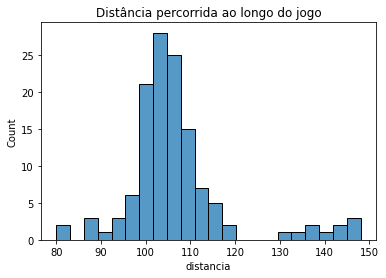

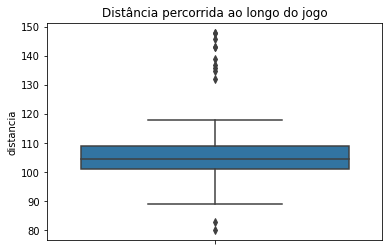

In [27]:
# histogram
plt.figure() 
sn.histplot(data['distancia'])
plt.title('Distância percorrida ao longo do jogo') 
plt.show()

# boxplot
plt.figure() 
sn.boxplot(y = data['distancia'])
plt.title('Distância percorrida ao longo do jogo')
plt.show()

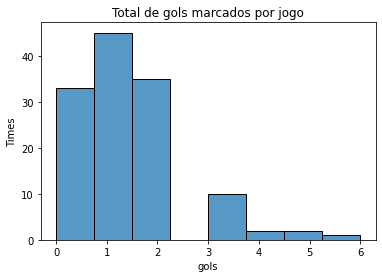

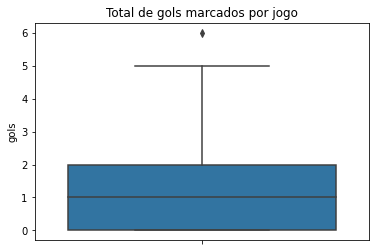

In [30]:
# histograma
plt.figure() 
sn.histplot(data['gols'])
plt.title('Total de gols marcados por jogo')
plt.ylabel("Times")
plt.show()

# boxplot
plt.figure() 
sn.boxplot(y = data['gols'])
plt.title('Total de gols marcados por jogo')
plt.show()

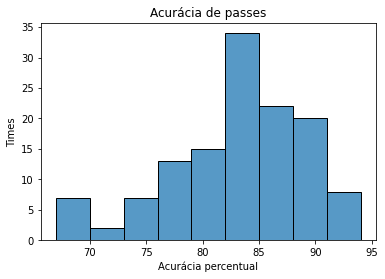

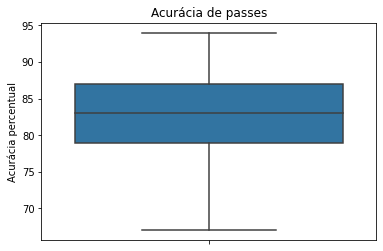

In [32]:
# histograma
plt.figure() 
sn.histplot(data['acuracia_passes'])
plt.title('Acurácia de passes')
plt.xlabel("Acurácia percentual")
plt.ylabel("Times")
plt.show()

# boxplot
plt.figure() 
sn.boxplot(y = data['acuracia_passes'])
plt.title('Acurácia de passes')
plt.ylabel("Acurácia percentual")
plt.show()

# Exercício 3

## Intervalo de Confiança

Pra começar, crie um conjunto de pontos artificial que siga uma distribuição gaussiana para representar a nossa população.<br/>

Em seguida, escolha um tamanho de amostra e calcule o intervalo de confiança de 95,4%.

Seja curioso e plote seus dados para visualizar!

Comando a ser utilizado para gerar a população:

* populacao = np.random.normal(média, desvio-padrão, tamanho_população)

Fórmula para calcular o intervalo de confiança:

$$ \overline{x} \pm 2\frac{\overline{\sigma}}{\sqrt{n}} $$


<Figure size 432x288 with 0 Axes>

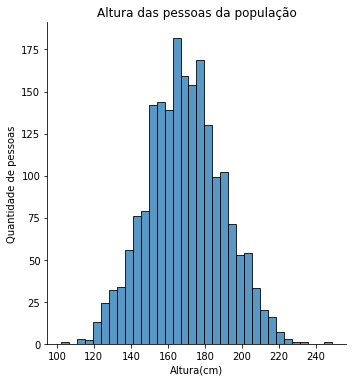

In [44]:
# Altura em centímetros de um grupo de pessoas.
populacao = np.random.normal(170, 20, 2000)

plt.figure() 
sn.displot(populacao)
plt.title('Altura das pessoas da população')
plt.xlabel("Altura(cm)")
plt.ylabel("Quantidade de pessoas")
plt.show()

In [45]:
tamanho_amostra = 100
ic_esquerda = 170 - ((2*20)/np.sqrt(100))
ic_direita = 170 + ((2*20)/np.sqrt(100))
print("Intervalo de confiança da amostra: [{};{}]".format(ic_esquerda, ic_direita))

Intervalo de confiança da amostra: [166.0;174.0]


## Repita com o dataset que estamos utilizando!

Dessa vez, use as distâncias percorridas pelos jogadores no conjunto de dados que estamos utilizando! 

Se for gerada uma amostra de tamanho 40, qual o intervalo de confiança de 95,4% da média dessas distâncias?



In [85]:
tamanho_amostra = 40
media_distancia = data['distancia'].mean()
desvio_distancia = data['distancia'].std()

ic_esquerda = media_distancia - ((2*desvio_distancia)/np.sqrt(tamanho_amostra))
ic_direita = media_distancia + ((2*desvio_distancia)/np.sqrt(tamanho_amostra))
print("Intervalo de confiança da amostra: [{};{}]".format(ic_esquerda, ic_direita))

Intervalo de confiança da amostra: [102.9485327704379;110.3795922295621]


### Vamos fazer um teste! 

Vamos agora investigar a influência do tamanho da amostra no intervalo de confiança. 

Na célula abaixo será criada uma população artificial que segue uma distribuição gaussiana. A partir dessa população,  uma serie de amostragens será feita para cacular o intervalo de confiança para o valor médio da população. 

Teste diferentes tamanhos de amostragem e, com o auxilo do gráfico gerado, diga o que acontece com o intervalo de confiança.

In [71]:
#@title Rode a célula (Clique 2 vezes para ver o código)

def intervalo_confi(pop, n):
    
    '''
    Função para o calculo do valor médio e intervalo de confiança de uma amostra
    INPUT: pop - População total
           n   - Tamanho da amostra
           
    OUTPUT: media_amostra - Valor médio da amostra extraida
            intervalo     - Lista com o valor inferior e superior do intervalo de confiança
    '''
    
    amostra = np.random.choice(pop, n, replace=False)
    
    # Valor médio da amostra coletada
    media_amostra = amostra.mean()
    # Desvio padrão da amostra coletada
    std_amostra = amostra.std()
    
    intervalo = [media_amostra - 2*std_amostra/np.sqrt(n), media_amostra + 2*std_amostra/np.sqrt(n)]
    
    return media_amostra, intervalo

# -----------------------------------------------------------------------------

def plot_intervalo (tamanho_n, numero_amostras, populacao):
    
    '''
    Função para criar o gráfico do intervalo de confiança para diferentes amostras e 
    comparar com o valor médio real da população
    INPUT: tamanho_n -       Tamanho das amostras extraidas da população total
           numero_amostras - Número de amostras extraida da população total
    '''

    fig = go.Figure()

    # Add Trace

    # Linha vertical da verdadeira média da população
    mu = populacao.mean()
    fig.add_vline(mu)

    k = 0
    # Add intervalos e médias
    for i in range(numero_amostras):

        media, inter = intervalo_confi(populacao, tamanho_n)

        color = 'black' if ((mu < inter[1]) & (mu > inter[0])) else 'red'
        if ((mu < inter[1]) & (mu > inter[0])) :
          k += 1 

        fig.add_trace(go.Scatter(x = inter,
                                 y = [i,i],
                                 mode = 'lines',
                                 line_color = color
                                ))
        fig.add_trace(go.Scatter(x = [media],
                                 y = [i], 
                                 mode = 'markers',
                                 marker_color = color
                                ))

    # Layout
    fig.update_layout(

        title = dict(

            text = f'Intervalo de 95,4% de confiança <br> para {numero_amostras} amostras de tamanho {tamanho_n}',
            font_size = 22,
            x = 0.5
        ),
        xaxis = dict(
            title_text = 'Intervalo de confiança',
            title_font_size = 20,
            tickfont_size = 18,
            range = (mu-1,mu+1)
        ),
        yaxis = dict(
            title_text = 'Amostras',
            title_font_size = 20,
            tickfont_size = 18
        ),

        height = 700,
        width = 600,
        showlegend = False
    )

    # Plot
    print(f'Porcentagens de vezes em que a média fica dentro do intervalo de confiança = { 100*k/numero_amostras}%')
    fig.show()

In [57]:
# Criando uma população artificial que segue uma distribuição gaussiana
media_pop = 0
std_pop = 1
tamanho_populacao = 10000
populacao = np.random.normal(media_pop,std_pop,tamanho_populacao)

# Dados o tamanho da amostra e a quantidade de amostras
# podemos criar um gráfico para verificar se o valor real
# da média da população está dentro do intervalo

tamanho_amostras=100
quantidade_amostragens=50

# Gráfico
plot_intervalo(tamanho_amostras, quantidade_amostragens, populacao)

print("A linha vertical representa o valor real da média da população total.")
print("Aquelas amostragens que não contem o valor real dentro do intervalo são marcadas como vermelhas.")


Porcentagens de vezes em que a média fica dentro do intervalo de confiança = 96.0%


A linha vertical representa o valor real da média da população total.
Aquelas amostragens que não contem o valor real dentro do intervalo são marcadas como vermelhas.


# Exercício 4

## Correlação de Pearson

Agora, calcule a correlação de Pearson entre as variáveis e plote o mapa de calor para facilitar a visualização

As funções abaixo podem ser úteis!

* Para calcular a matriz de correlação utilizando o pandas:
    * corr = data.corr(method='pearson')   
    
* Para plotar o mapa de calor
    * ax=sn.heatmap(corr, annot=True, fmt=".2f")
    

In [69]:
print("Correlação entre faltas e cartões")
faltas = data[['amarelos', 'vermelhos','faltas']]
corr = faltas.corr(method='pearson')
print(corr)

Correlação entre faltas e cartões
           amarelos  vermelhos  faltas
amarelos       1.00       0.03    0.43
vermelhos      0.03       1.00    0.01
faltas         0.43       0.01    1.00



 Mapa de calor do dataset FIFA 2018


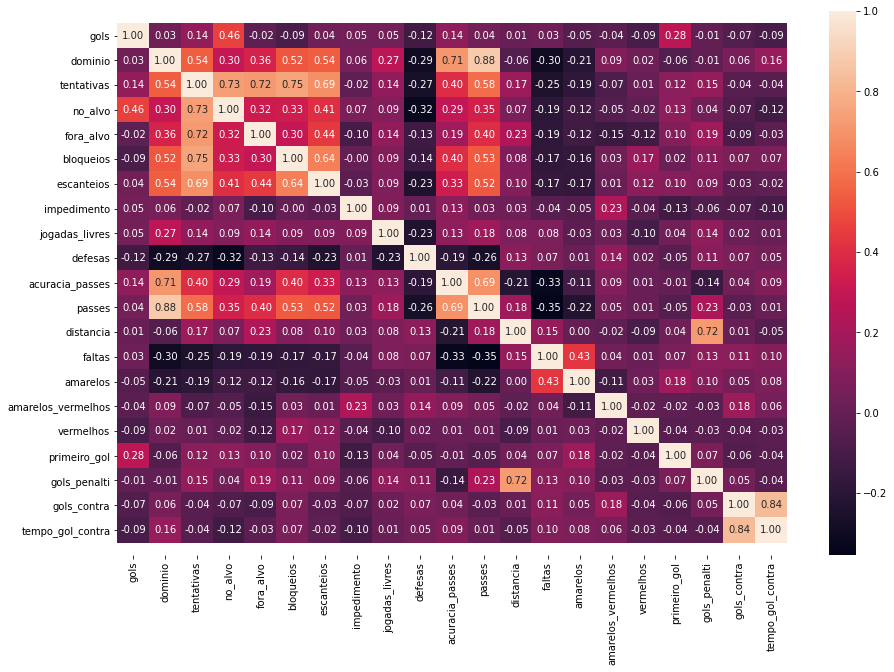

In [73]:
print("\n Mapa de calor do dataset FIFA 2018")
corr = data.corr(method='pearson')
plt.figure(figsize=(15,10))
ax=sn.heatmap(corr, annot=True, fmt=".2f")
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

# Exercício 5

## Análise Fatorial

Agora vamos realizar a análise fatorial! <br/>
<br/>
<br/>
Para começar, faça o teste de esfericidade de Bartlett e de calcule a medida de adequacidade da amostra de Kaiser-Meyer-Olkia.
<br/>
As funções abaixos serão úteis:
* Para realizar o teste de esfericidade de Bartlett
    * _,p_value=calculate_bartlett_sphericity(data)
* Para calcular a medida de adequacidade da amostra de Kaiser-Meyer-Olkia
    * _,kmo_model=calculate_kmo(data)

In [66]:
_,p_value=calculate_bartlett_sphericity(data.astype('float32'))
print(_,p_value)

_,kmo_model=calculate_kmo(data)
print(_,kmo_model)

(2071.994980533597, 7.481069659659384e-283)

Agora, vamos decidir quantos fatores utilizar<br/>
<br/>

Realize a análise fatorial e veja quantos auto valores são altos

* Primeiro realize a análise fatorial
    * fa = FactorAnalyzer()
    * fa.fit(data)
* Em seguida, calcule os auto valores da decomposição fatorial
    * ev, vectors = fa.get_eigenvalues()
    
* Plote os auto valores
    

In [86]:
fa = FactorAnalyzer()
fa.fit(data)
ev, vectors = fa.get_eigenvalues()

Escreva na célula abaixo quantos fatores você escolheu utilizar e porque.

Agora sim! 
Realize a análise fatorial com a quantidade de fatores X escolhida

Você pode utilizar os seguintes comandos:
* fa = FactorAnalyzer()
* fa.set_params(n_factors=X, rotation='varimax')
* fa.fit(data)
* loadings = fa.loadings_

Você pode plotar para facilitar a análise dos resultado, se desejar.

In [ ]:
# Utilize esta célula para realizar a análise



Escreva na célula seguinte quais variáveis estão relacionadas a quais fatores e o que você acha que eles representam!